In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.15.0
1.25.2


## data load

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [5]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)
print(ds_info.features)

120
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})


In [6]:
# Cutmix 증강

# image a를 바탕으로 b를 추가할때
# a에 추가할 바운딩 박스의 위치를 구하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

# 바탕이미지 a에 b를 바운딩 박스에 추가하여 합성하는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역

    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

# 두 이미지를 합성했기에 라벨도 그에 따라 비율(이미지의 면적)에 따라 변경해주어야함
# ex) a이미지가 전체 이미지대비 0.4 라면 a label의 * 0.4 b label은 *0.6
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# cutmix 사용 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [7]:
# Mixup 증강

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# num_classes = 120
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, is_onehot=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )

    # 테스트가 아니고 일반 aug
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)

    # 테스트가 아니고 cutmix
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    # 테스트가 아니고 mixup
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    # test데이터가 cutmix이거나 mixup 일때
    if is_onehot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )


    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# augmentation이 없는 데이터
ds_train_no_aug = apply_normalize_on_dataset(ds_train)

# 랜덤뒤집기, 밝기 aug적용
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# cutmix aug
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

# mixup aug
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

# onehot 적용안한 테스트 데이터
ds_test_no_onehot = apply_normalize_on_dataset(ds_test, is_test=True)

# onehot 적용한 테스트 데이터
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, is_onehot=True)

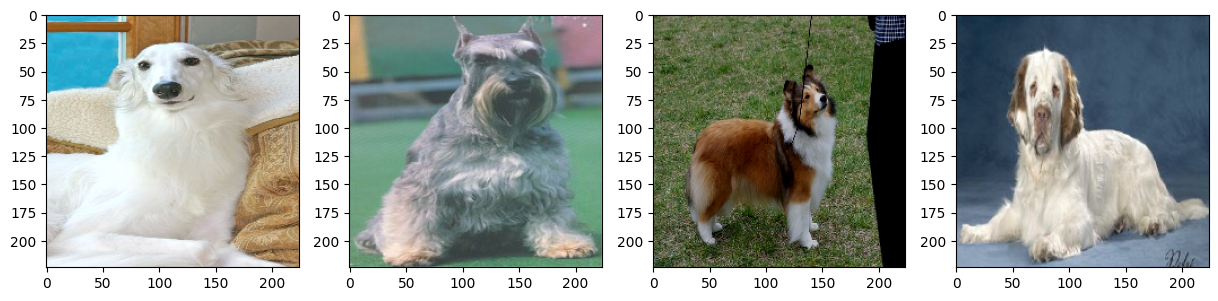

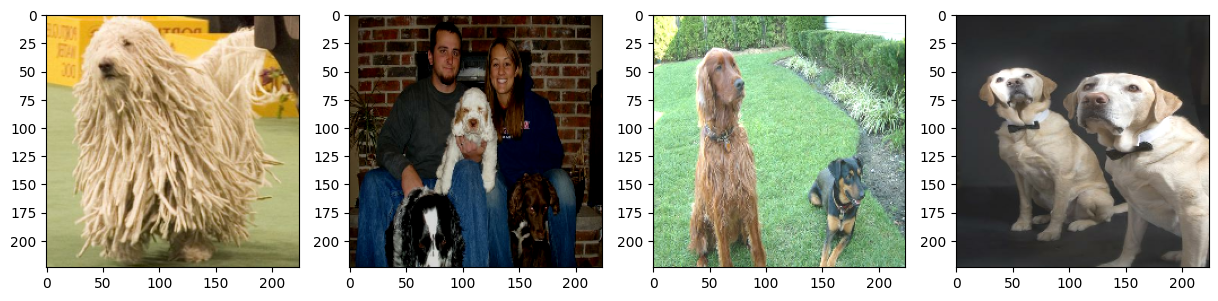

In [10]:
# 랜덤뒤집기, 밝기 aug 적용 확인용
# cutmix aug 확인용
for i, (image, label) in enumerate(ds_train_aug.take(2)):

    plt.figure(figsize=(15, 10))

    plt.subplot(1,4,1)
    plt.imshow(image[0])

    plt.subplot(1,4,2)
    plt.imshow(image[1])

    plt.subplot(1,4,3)
    plt.imshow(image[2])

    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

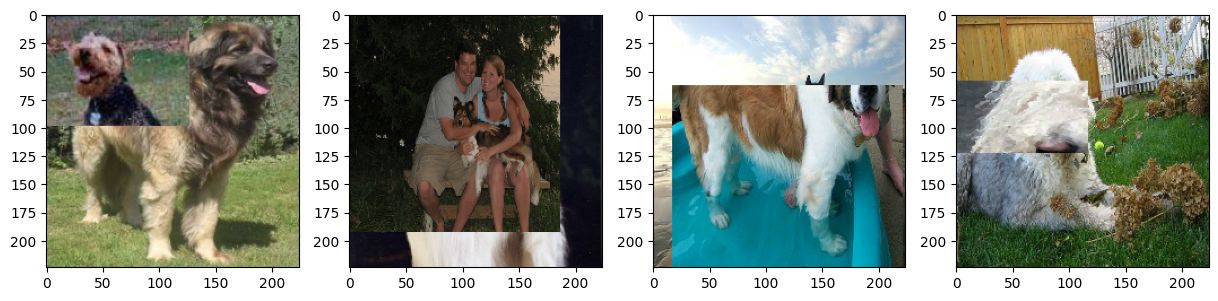

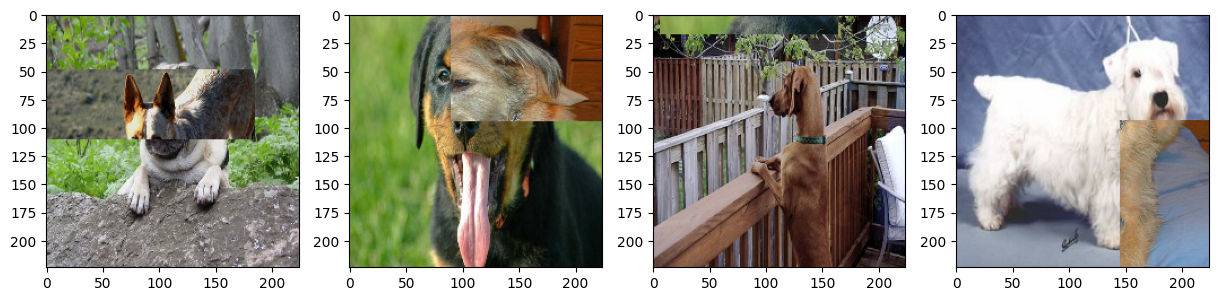

In [11]:
# cutmix aug 확인용
for i, (image, label) in enumerate(ds_train_cutmix.take(2)):

    plt.figure(figsize=(15, 10))

    plt.subplot(1,4,1)
    plt.imshow(image[0])

    plt.subplot(1,4,2)
    plt.imshow(image[1])

    plt.subplot(1,4,3)
    plt.imshow(image[2])

    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

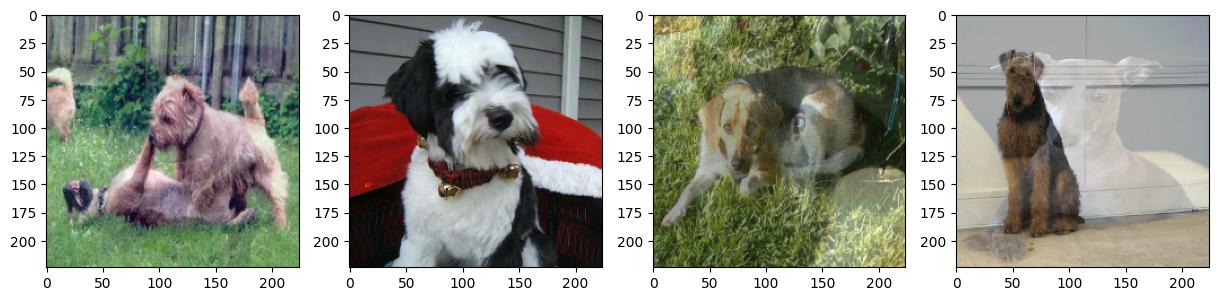

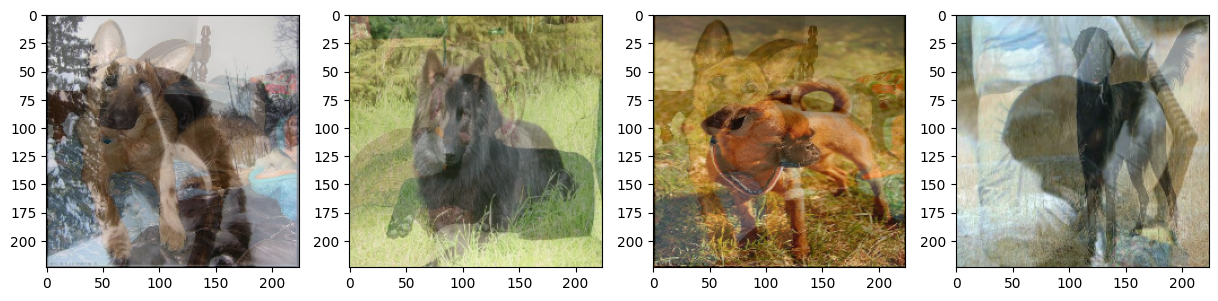

In [12]:
# mixup aug 확인용

for i, (image, label) in enumerate(ds_train_mixup.take(2)):

    plt.figure(figsize=(15, 10))

    plt.subplot(1,4,1)
    plt.imshow(image[0])

    plt.subplot(1,4,2)
    plt.imshow(image[1])

    plt.subplot(1,4,3)
    plt.imshow(image[2])

    plt.subplot(1,4,4)
    plt.imshow(image[3])

    plt.show()

    if i == 1:
        break

## Model 구성

In [13]:
# no aug 훈련용 model
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 랜덤뒤집기, 밝기 aug적용한 훈련용 model
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix aug 적용한 훈련용 model
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# mixup aug 적용한 훈련용 model
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


## Model compile 및 fit

In [14]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [15]:
# no aug
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_no_aug.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],

)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2346 - accuracy: 0.4406
Epoch 1: val_accuracy improved from -inf to 0.18633, saving model to resnet50_no_aug.h5
750/750 [==============================] - 185s 211ms/step - loss: 2.2346 - accuracy: 0.4406 - val_loss: 3.4145 - val_accuracy: 0.1863
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.7980
Epoch 2: val_accuracy improved from 0.18633 to 0.63223, saving model to resnet50_no_aug.h5
750/750 [==============================] - 172s 229ms/step - loss: 0.7331 - accuracy: 0.7980 - val_loss: 1.3485 - val_accuracy: 0.6322
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9433
Epoch 3: val_accuracy improved from 0.63223 to 0.72027, saving model to resnet50_no_aug.h5
750/750 [==============================] - 172s 230ms/step - loss: 0.2554 - accuracy: 0.9433 - val_loss: 0.9679 - val_accuracy: 0.7203
Epoch 4/20
750/750 [=================

In [16]:
# 랜덤뒤집기, 밝기 aug적용한 훈련용 model
resnet50_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_aug.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 랜덤 뒤집기, 밝기 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2810 - accuracy: 0.4288
Epoch 1: val_accuracy improved from -inf to 0.29233, saving model to resnet50_aug.h5
750/750 [==============================] - 192s 230ms/step - loss: 2.2810 - accuracy: 0.4288 - val_loss: 2.8291 - val_accuracy: 0.2923
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.7313
Epoch 2: val_accuracy improved from 0.29233 to 0.60541, saving model to resnet50_aug.h5
750/750 [==============================] - 172s 229ms/step - loss: 0.9306 - accuracy: 0.7313 - val_loss: 1.3607 - val_accuracy: 0.6054
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.8557
Epoch 3: val_accuracy improved from 0.60541 to 0.67736, saving model to resnet50_aug.h5
750/750 [==============================] - 157s 209ms/step - loss: 0.5194 - accuracy: 0.8557 - val_loss: 1.0902 - val_accuracy: 0.6774
Epoch 4/20
750/750 [==========================

In [17]:
# cutmix aug 적용한 훈련용 model
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_cutmix.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 3.8049 - accuracy: 0.2107
Epoch 1: val_accuracy improved from -inf to 0.18493, saving model to resnet50_cutmix.h5
750/750 [==============================] - 181s 213ms/step - loss: 3.8049 - accuracy: 0.2107 - val_loss: 3.4763 - val_accuracy: 0.1849
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 2.9205 - accuracy: 0.4429
Epoch 2: val_accuracy improved from 0.18493 to 0.57229, saving model to resnet50_cutmix.h5
750/750 [==============================] - 173s 231ms/step - loss: 2.9205 - accuracy: 0.4429 - val_loss: 1.5433 - val_accuracy: 0.5723
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 2.6129 - accuracy: 0.5452
Epoch 3: val_accuracy improved from 0.57229 to 0.65322, saving model to resnet50_cutmix.h5
750/750 [==============================] - 174s 232ms/step - loss: 2.6129 - accuracy: 0.5452 - val_loss: 1.2541 - val_accuracy: 0.6532
Epoch 4/20
750/750 [=================

# mixup 에서 GPU 다써서 날렸다...
- lms에서 돌릴때는 history 객체를 pickle로 저장하는 부분 추가

In [1]:
# mixup aug 적용한 훈련용 model
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

checkpoint = keras.callbacks.ModelCheckpoint("resnet50_mixup.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
)

NameError: name 'resnet50_mixup' is not defined

# 훈련결과 시각화

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], color='red', linestyle='-', linewidth=2, marker='o')
plt.plot(history_resnet50_aug.history['val_accuracy'], color='blue', linestyle='--', linewidth=2, marker='s')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], color='green', linestyle='-.', linewidth=2, marker='^')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='purple', linestyle=':', linewidth=2, marker='d')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_loss'], color='red', linestyle='-', linewidth=2, marker='o')
plt.plot(history_resnet50_aug.history['val_loss'], color='blue', linestyle='--', linewidth=2, marker='s')
plt.plot(history_resnet50_cutmix.history['val_loss'], color='green', linestyle='-.', linewidth=2, marker='^')
plt.plot(history_resnet50_mixup.history['val_loss'], color='purple', linestyle=':', linewidth=2, marker='d')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()

# history 저장

In [ ]:
import pickle
import gzip

file_names = ['history_resnet50_no_aug', 'history_resnet50_aug','history_resnet50_cutmix','history_resnet50_mixup']
histories = [history_resnet50_no_aug,history_resnet50_aug,history_resnet50_cutmix,history_resnet50_mixup]

for file_name, history in enumerate(file_names, histories):
  # save history
  with gzip.open(f'{file_name}.pickle', 'wb') as f:
      pickle.dump(history, f)

# load test
with gzip.open('history_resnet50_no_aug.pickle','rb') as f:
    load_history = pickle.load(f)
    print(load_history)

